In [1]:
import pandas as pd
import numpy as np

In [2]:
prices = pd.read_csv("Prices/BTC-USD.csv")
prices.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


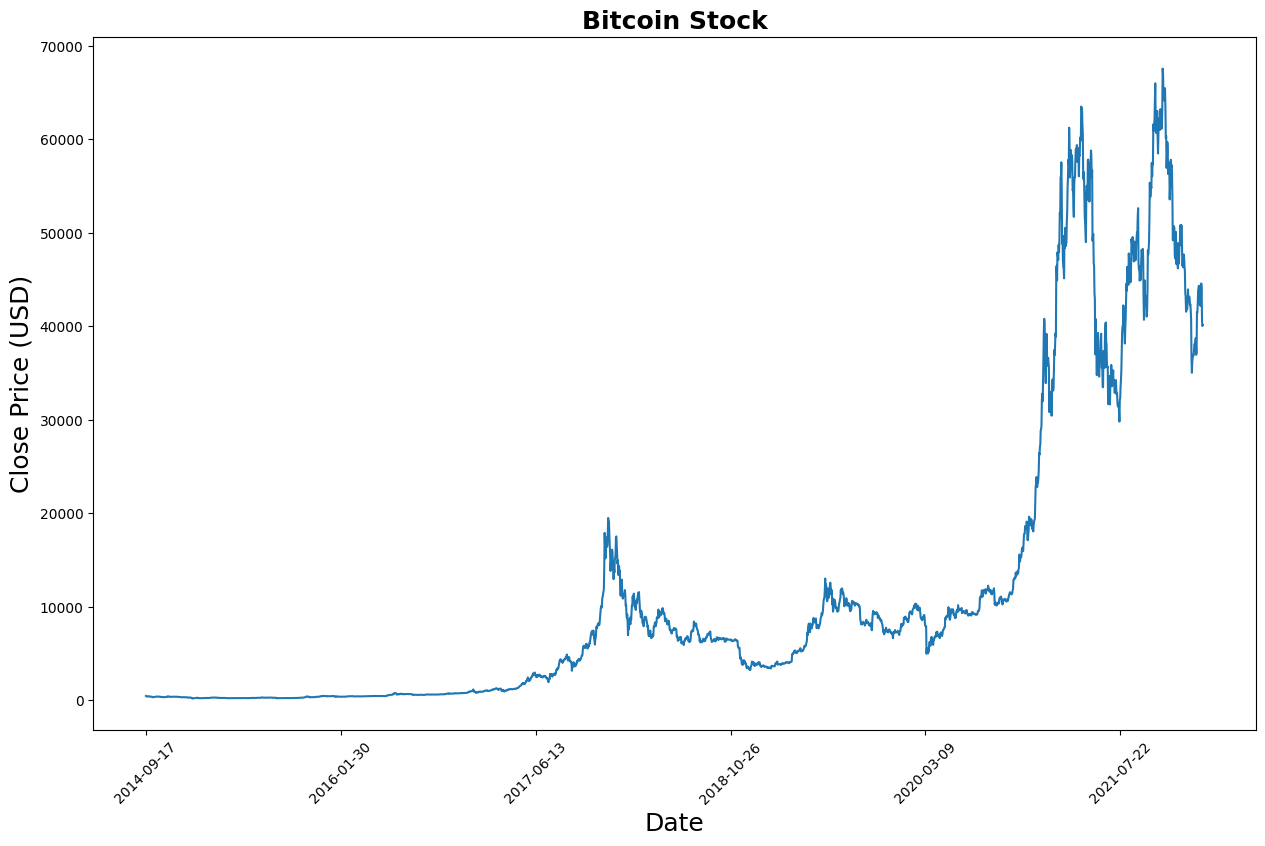

In [3]:
import matplotlib.pyplot as plt

# sns.set_style("darkgrid")
plt.figure(figsize = (15,9))
plt.plot(prices[['Close']])
plt.xticks(range(0,prices.shape[0],500),prices['Date'].loc[::500],rotation=45)
plt.title("Bitcoin Stock",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()

In [4]:
price = prices[['Close']]
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2713 entries, 0 to 2712
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2713 non-null   float64
dtypes: float64(1)
memory usage: 21.3 KB


In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1, 1))

/tmp/ipykernel_347751/1783556213.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1, 1))


In [6]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    # Cria janelas de valores tipo convoluções
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data)
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [7]:
lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (2154, 19, 1)
y_train.shape =  (2154, 1)
x_test.shape =  (539, 19, 1)
y_test.shape =  (539, 1)


In [8]:
import torch
import torch.nn as nn

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [9]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [20]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [21]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [22]:
import time

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.5578141212463379
Epoch  1 MSE:  0.3195175230503082
Epoch  2 MSE:  0.11901618540287018
Epoch  3 MSE:  0.017085997387766838
Epoch  4 MSE:  0.12900446355342865
Epoch  5 MSE:  0.035551443696022034
Epoch  6 MSE:  0.014738474041223526
Epoch  7 MSE:  0.03608866408467293
Epoch  8 MSE:  0.048839133232831955
Epoch  9 MSE:  0.04613629728555679
Epoch  10 MSE:  0.03496209532022476
Epoch  11 MSE:  0.02286716178059578
Epoch  12 MSE:  0.0151174021884799
Epoch  13 MSE:  0.013757002539932728
Epoch  14 MSE:  0.01735786721110344
Epoch  15 MSE:  0.02213730849325657
Epoch  16 MSE:  0.02453998290002346
Epoch  17 MSE:  0.023422956466674805
Epoch  18 MSE:  0.02003559097647667
Epoch  19 MSE:  0.016464192420244217
Epoch  20 MSE:  0.014214245602488518
Epoch  21 MSE:  0.013710726983845234
Epoch  22 MSE:  0.014531183056533337
Epoch  23 MSE:  0.01589393988251686
Epoch  24 MSE:  0.01706826500594616
Epoch  25 MSE:  0.017596833407878876
Epoch  26 MSE:  0.017353860661387444
Epoch  27 MSE:  0.01649776846

In [23]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

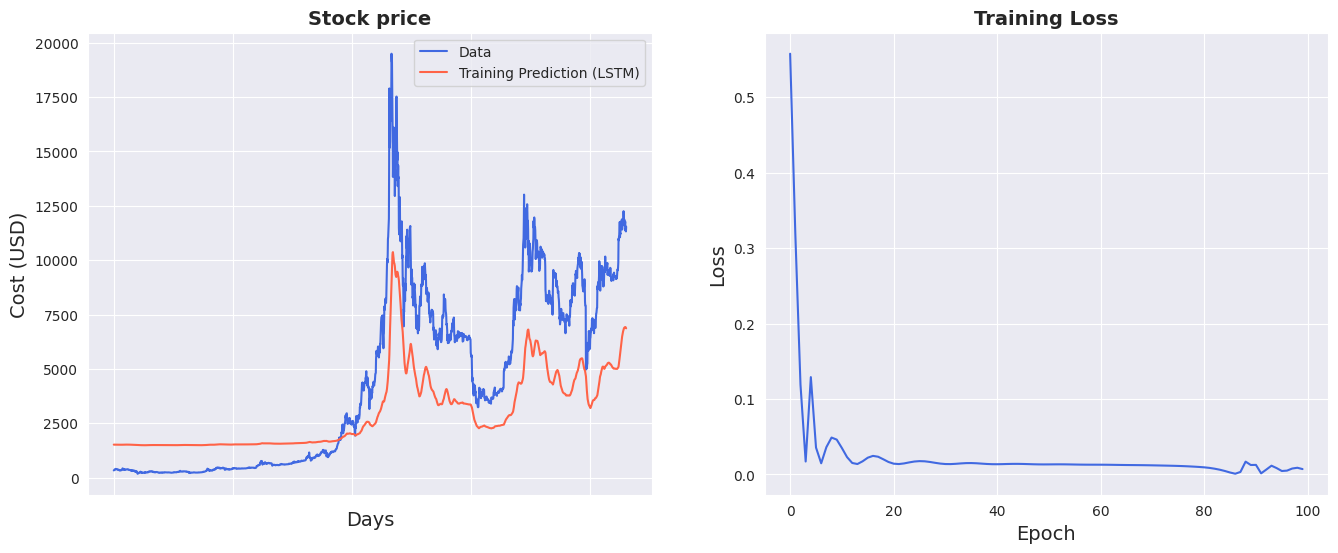

In [24]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [15]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [16]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [17]:
hist = np.zeros(num_epochs)
start_time = time.time()
gru = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_gru)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time()-start_time    
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.7859993577003479
Epoch  1 MSE:  0.2685511112213135
Epoch  2 MSE:  0.013398292474448681
Epoch  3 MSE:  0.19487114250659943
Epoch  4 MSE:  0.09958385676145554
Epoch  5 MSE:  0.011619631201028824
Epoch  6 MSE:  0.030518563464283943
Epoch  7 MSE:  0.06971105933189392
Epoch  8 MSE:  0.0805399939417839
Epoch  9 MSE:  0.06443934142589569
Epoch  10 MSE:  0.03765120729804039
Epoch  11 MSE:  0.01597655937075615
Epoch  12 MSE:  0.009210281074047089
Epoch  13 MSE:  0.017228800803422928
Epoch  14 MSE:  0.02964881993830204
Epoch  15 MSE:  0.034268371760845184
Epoch  16 MSE:  0.028064681217074394
Epoch  17 MSE:  0.01746414788067341
Epoch  18 MSE:  0.010114269331097603
Epoch  19 MSE:  0.009049137122929096
Epoch  20 MSE:  0.012617346830666065
Epoch  21 MSE:  0.017223645001649857
Epoch  22 MSE:  0.019848709926009178
Epoch  23 MSE:  0.019257009029388428
Epoch  24 MSE:  0.01603274792432785
Epoch  25 MSE:  0.011934586800634861
Epoch  26 MSE:  0.00894856546074152
Epoch  27 MSE:  0.008306188

In [18]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_gru.detach().numpy()))

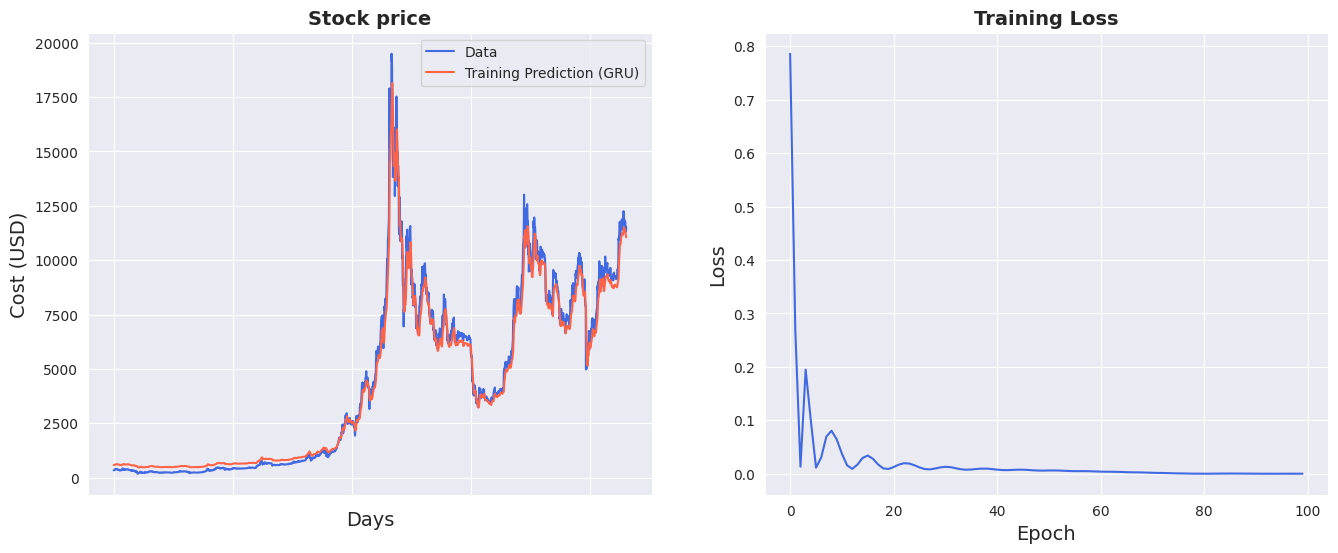

In [19]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (GRU)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)